# Project 2. Deep Learning        Consolidado DL
## Image Classification with CNN

#### Sandra Marcela Meneses - Angélica María Gómez Buitrago - Juan Camilo Castillo Castro - Diego Fernando López Castillo

Se tiene un conjunto de 600 imágenes, de 6 categorías distintas de clases de pájaros. Se tienen 100 imágenes de cada clase

# 0. Preparacion de los datos

In [1]:
import zipfile

zf = zipfile.ZipFile('../Proyecto_Aves/birds.zip', 'r')
zf.extractall(path='../Proyecto_Aves/DL/')



In [2]:
import os,shutil
import pandas as pd
from pathlib import Path,PureWindowsPath
DIR = '../Proyecto_Aves/birds/'
TRAIN_DIR = '../Proyecto_Aves/train/'
TEST_DIR = '../Proyecto_Aves/test/'
#Categoria = os.listdir('../Proyecto_Aves/DL/birds/')
Categoria = os.listdir(DIR)

In [3]:
print(Categoria)

['egret', 'mandarin', 'owl', 'puffin', 'toucan', 'wood_duck']


### 0.1 Creacion de Carpetas Train y Test

In [4]:
for i in range(0,6):
    traindir= PureWindowsPath(TRAIN_DIR,Categoria[i])
    os.makedirs(traindir)
    print(traindir)
    testdir= PureWindowsPath(TEST_DIR,Categoria[i])
    os.makedirs(testdir)
    print(testdir)

..\Proyecto_Aves\train\egret
..\Proyecto_Aves\test\egret
..\Proyecto_Aves\train\mandarin
..\Proyecto_Aves\test\mandarin
..\Proyecto_Aves\train\owl
..\Proyecto_Aves\test\owl
..\Proyecto_Aves\train\puffin
..\Proyecto_Aves\test\puffin
..\Proyecto_Aves\train\toucan
..\Proyecto_Aves\test\toucan
..\Proyecto_Aves\train\wood_duck
..\Proyecto_Aves\test\wood_duck


### 0.2 Separacion de imagenes Train y Test

In [5]:
from sklearn.model_selection import train_test_split
import os, sys

In [6]:
for i in range(0,6):
    src_path= Path(DIR,Categoria[i])
    dst_train= Path(TRAIN_DIR,Categoria[i])
    dst_test= Path(TEST_DIR,Categoria[i])
    X_train, X_test = train_test_split(os.listdir(src_path), test_size=0.5, random_state=42)
    for fname1 in X_train:
        src = os.path.join(src_path, fname1)
        dst = os.path.join(dst_train, fname1)
        shutil.copyfile(src, dst)
        
    for fname2 in X_test:
        src = os.path.join(src_path, fname2)
        dst2 = os.path.join(dst_test, fname2)
        shutil.copyfile(src, dst2)

# *Punto 1. Direct prediction*

Download the dataset birds from http://www-cvr.ai.uiuc.edu/ponce_grp/data/.
Use Keras and a CNN from Keras Applications pretrained on ImageNet, to classify the images in the birds dataset. Construct a confusion matrix that relates the bird classes with the 10 most frequent classes from ImageNet predicted by the model.
Discuss the results.

## *Introducción:*

#### Librerias

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img,array_to_img,load_img,image
from keras.applications.vgg16 import decode_predictions
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [8]:
# Only the first training batch and testing  # File is 58MB
import zipfile
for filename in ['birds.zip']:
    print('{:>15}  {}'.format(
        filename, zipfile.is_zipfile(filename)))

zf = zipfile.ZipFile('../Proyecto_Aves/birds.zip', 'r')
zf.extractall(path='../Proyecto_Aves/')

      birds.zip  True


In [9]:
zf.namelist()[0:10]

['birds/',
 'birds/egret/',
 'birds/egret/egr001.jpg',
 'birds/egret/egr002.jpg',
 'birds/egret/egr003.jpg',
 'birds/egret/egr004.jpg',
 'birds/egret/egr005.jpg',
 'birds/egret/egr006.jpg',
 'birds/egret/egr007.jpg',
 'birds/egret/egr008.jpg']

#### Visualización previa de imágenes

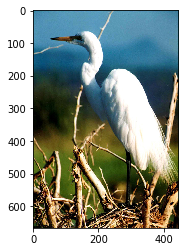

In [10]:
%matplotlib inline

img = load_img('birds/egret/egr006.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
plt.imshow(img)
plt.show()

#### Ejemplo de generación de imágenes
* Rotación de imagen 

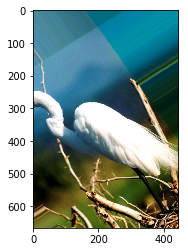

In [11]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('birds/egret/egr006.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, _, _)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, _, _)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
plt.imshow(batch[0]/255) 
plt.show()

## *Implementación:*

**Explicación 1: ** Se definen los siguientes parámetros:
* Dimensión de las imágenes 
* Directorio de entrada
* Batch_size

In [12]:
img_width, img_height = 224, 224
#top_model_weights_path = 'bottleneck_fc_model.h5'
data_dir = 'birds'
#epochs = 50
batch_size = 16

**Explicación 2:** Se extrae los pesos de la red neuronal pre-entrenada VGG16, especificando el parámetro include_top=true, para implementar el uso de todas las capas.

In [13]:
# build the MobileNet network
model = applications.MobileNet(include_top=True, weights='imagenet')

17227776/17225924 [==============================] - 39s 2us/step


* Estructura de la red VGG16 incluyendo la capa predictions (Dense) (None, 1000)  Param: 4097000

In [14]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 226, 226, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 112, 112, 32)      864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 112, 112, 32)      128       
_________________________________________________________________
conv1_relu (Activation)      (None, 112, 112, 32)      0         
_________________________________________________________________
conv_pad_1 (ZeroPadding2D)   (None, 114, 114, 32)      0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)      288       
__________

**Explicación 3:** Se crea un generador utilizando los parámetros en la -Explicación 1-  
* **-directory=data_dir-**, Garantiza el acceso al directorio con las imagenes de aves
* **-class_mode = None-** significa que el generador solo producirá lotes de datos sin etiquetas 
* **-shuffle    = False-** garantiza que los datos estarán en orden, entonces las primeras 100 imágenes corresponderán a egret, las siguientes 100 a la categoría  owl, y así mismo para las clasificaciones puffin, toucan y wood_duck.  

Puede observarse que encontró 600 imágenes distribuidas en 6 clases

In [15]:
datagen = ImageDataGenerator(rescale=1. / 255) #se reescala para que queden valores entre 0 y 1 
       
generator = datagen.flow_from_directory(
    directory   = data_dir,
    target_size = (img_width, img_height),
    batch_size  = batch_size,
    class_mode  = None,
    shuffle     = False)

Found 600 images belonging to 6 classes.


**Explicación 4:** Se define parámetros adicionales 

* **nb_data_samples** : Número de registros

In [16]:
nb_data_samples    = len(generator.filenames)
print(nb_data_samples)

600


* **num_classes** : Número de clases

In [17]:
num_classes       = len(generator.class_indices) 
num_classes 

6

* **predict_size ** : Uso de bits en la predicción

In [18]:
predict_size        = int(math.ceil(nb_data_samples / batch_size))
predict_size

38

**Explicación 5:** Predicción utilizando toda la esquematización de la red neuronal VGG16

In [19]:
pred_VGG16          = model.predict_generator(generator, predict_size)

C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 80000 bytes but only got 0. Skipping tag 64640
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2652897280 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 2656043008 bytes but only got 0. Skipping tag 2
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt EXIF data.  Expecting to read 65536 bytes but only got 0. Skipping tag 3
  " Skipping tag %s" % (size, len(data), tag))
C:\ProgramData\Anaconda3\lib\site-packages\PIL\TiffImagePlugin.py:739: UserWarning: Possibly corrupt E

**Explicación 6:** Predicción en términos de la (Probabilidad)

In [20]:
pred_VGG16

array([[1.7183680e-06, 1.3856037e-07, 3.7043039e-05, ..., 2.4035774e-07,
        3.6173933e-05, 2.8261693e-06],
       [2.3078330e-10, 2.4457214e-10, 7.0570643e-09, ..., 1.6017572e-10,
        1.5656981e-09, 2.3397984e-10],
       [1.0425999e-09, 4.1076454e-08, 7.9694040e-08, ..., 7.3645984e-10,
        1.0547917e-08, 9.8063592e-06],
       ...,
       [7.5652451e-08, 9.6325596e-09, 1.0121423e-08, ..., 8.4357174e-11,
        2.6720773e-08, 5.5770120e-06],
       [1.0388756e-04, 8.6978389e-07, 1.4232251e-05, ..., 4.0627842e-06,
        1.7394625e-06, 8.4359726e-06],
       [6.9949500e-08, 7.3927959e-07, 2.7289042e-07, ..., 4.1337012e-10,
        2.4783070e-08, 1.3578207e-07]], dtype=float32)

**Explicación 7:** Dimensión del vector de predicción: 600 registros x 1000 columnas que corresponden a las categorías para entrenar la red VGG16

In [21]:
pred_VGG16.shape

(600, 1000)

**Explicación 8:** Se decodifica las predicciones incorporando las categorías    

In [22]:
label = decode_predictions(pred_VGG16)
label

40960/35363 [==================================] - 0s 0us/step


[[('n02009912', 'American_egret', 0.7788372),
  ('n02009229', 'little_blue_heron', 0.113266066),
  ('n02006656', 'spoonbill', 0.018391587),
  ('n01580077', 'jay', 0.015006038),
  ('n01819313', 'sulphur-crested_cockatoo', 0.014503019)],
 [('n02009912', 'American_egret', 0.9893048),
  ('n02012849', 'crane', 0.009847723),
  ('n02006656', 'spoonbill', 0.00050136354),
  ('n02009229', 'little_blue_heron', 0.00022029124),
  ('n02007558', 'flamingo', 6.294895e-05)],
 [('n02009912', 'American_egret', 0.88776326),
  ('n02012849', 'crane', 0.102436796),
  ('n02009229', 'little_blue_heron', 0.0059003253),
  ('n02002556', 'white_stork', 0.0013604036),
  ('n02007558', 'flamingo', 0.0013268194)],
 [('n02009912', 'American_egret', 0.9825142),
  ('n02012849', 'crane', 0.014763118),
  ('n02009229', 'little_blue_heron', 0.0020692085),
  ('n02006656', 'spoonbill', 0.00054320914),
  ('n02002556', 'white_stork', 5.6264085e-05)],
 [('n02009912', 'American_egret', 0.95125586),
  ('n02012849', 'crane', 0.02375

**Explicación 9:** Se extrae el vector de categorías 

In [23]:
decode_predictions(pred_VGG16,top=10)

[[('n02009912', 'American_egret', 0.7788372),
  ('n02009229', 'little_blue_heron', 0.113266066),
  ('n02006656', 'spoonbill', 0.018391587),
  ('n01580077', 'jay', 0.015006038),
  ('n01819313', 'sulphur-crested_cockatoo', 0.014503019),
  ('n02051845', 'pelican', 0.01126509),
  ('n01582220', 'magpie', 0.010774512),
  ('n01592084', 'chickadee', 0.0036754103),
  ('n01608432', 'kite', 0.0036176692),
  ('n02058221', 'albatross', 0.003277512)],
 [('n02009912', 'American_egret', 0.9893048),
  ('n02012849', 'crane', 0.009847723),
  ('n02006656', 'spoonbill', 0.00050136354),
  ('n02009229', 'little_blue_heron', 0.00022029124),
  ('n02007558', 'flamingo', 6.294895e-05),
  ('n09332890', 'lakeside', 2.5105788e-05),
  ('n01855672', 'goose', 1.23704185e-05),
  ('n01819313', 'sulphur-crested_cockatoo', 9.067005e-06),
  ('n02002556', 'white_stork', 4.665287e-06),
  ('n01860187', 'black_swan', 4.1161475e-06)],
 [('n02009912', 'American_egret', 0.88776326),
  ('n02012849', 'crane', 0.102436796),
  ('n020

In [24]:
decode_predictions(pred_VGG16,top=1)[0][0][1]

'American_egret'

In [25]:
categoria=[]
for i in range(600): 
    label = decode_predictions(pred_VGG16,top=1)[i][0][1]
    categoria.append(label)
    
categoria= np.array(categoria)
categoria

array(['American_egret', 'American_egret', 'American_egret',
       'American_egret', 'American_egret', 'American_egret',
       'American_egret', 'American_egret', 'American_egret',
       'American_egret', 'American_egret', 'American_egret',
       'American_egret', 'American_egret', 'American_egret',
       'American_egret', 'American_egret', 'American_egret',
       'American_egret', 'American_egret', 'American_egret', 'spoonbill',
       'American_egret', 'American_egret', 'American_egret',
       'American_egret', 'American_egret', 'American_egret',
       'American_egret', 'American_egret', 'American_egret',
       'American_egret', 'American_egret', 'American_egret',
       'American_egret', 'American_egret', 'American_egret',
       'sulphur-crested_cockatoo', 'American_egret', 'American_egret',
       'American_egret', 'American_egret', 'American_egret',
       'American_egret', 'American_egret', 'little_blue_heron',
       'American_egret', 'American_egret', 'American_egret'

**Explicación 10:** Se construye un vector de tamaño 600 con las categorías originales distribuido asi: 

* 100 Repeticiones de "Egret"
* 100 ""   "Mandarin"
* 100 ""   "Owl"
* 100 ""   "Puffin"
* 100 ""   "Toucan"
* 100 ""   "Wood Duck"

In [26]:
x = np.array(["Egret","Mandarin","Owl","Puffin","Toucan","Wood Duck"])
ori_cat = np.repeat(x, [100], axis=0)
ori_cat

array(['Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret',
       'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret',
       'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret',
       'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret',
       'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret',
       'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret',
       'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret',
       'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret',
       'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret',
       'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret',
       'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret',
       'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret',
       'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret',
       'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret', 'Egret',
       'Egret', 'Egr

**Explicación 11:** Construcción de un data frame para las 600 fotos de aves originales y su respectiva predicción

In [27]:
d = {"Original":ori_cat,"Prediction":categoria}
matrix = pd.DataFrame(d)
matrix.head()

,Original,Prediction
0,Egret,American_egret
1,Egret,American_egret
2,Egret,American_egret
3,Egret,American_egret
4,Egret,American_egret


**Explicación 12:** Conteo de las 10 clases más frecuentes en la predicción

In [28]:
counter = matrix.groupby(['Prediction']).size()
counter = counter.sort_values(ascending=False)
counter[:10]

Prediction
drake             169
toucan            111
American_egret     92
ptarmigan          39
albatross          31
great_grey_owl     15
African_grey       14
goose              13
water_ouzel         7
king_penguin        6
dtype: int64

**Explicación 13:** Indexación de las 10 clases más frecuentes para ser utilizadas en el filtro desde el data frame **-matrix-**

In [29]:
most_commom = counter[:10].index
most_commom

Index(['drake', 'toucan', 'American_egret', 'ptarmigan', 'albatross',
       'great_grey_owl', 'African_grey', 'goose', 'water_ouzel',
       'king_penguin'],
      dtype='object', name='Prediction')

**Explicación 14:** Obtención del data frame final **-matrix_2-** que contiene los insumos para la construcción de la matriz de confusión

In [30]:
matrix_2 = matrix[matrix.Prediction.isin(most_commom)]
matrix_2.shape

(497, 2)

In [31]:
matrix_2.head()

,Original,Prediction
0,Egret,American_egret
1,Egret,American_egret
2,Egret,American_egret
3,Egret,American_egret
4,Egret,American_egret


**Explicación 15:** Definición de los **-labels-** para la matriz de confusión

In [32]:
def Union(lst1, lst2):
    final_list = lst1 + lst2
    return final_list

labels = Union(list(most_commom),["Egret","Mandarin","Owl","Puffin","Toucan","Wood Duck"])
labels

['drake',
 'toucan',
 'American_egret',
 'ptarmigan',
 'albatross',
 'great_grey_owl',
 'African_grey',
 'goose',
 'water_ouzel',
 'king_penguin',
 'Egret',
 'Mandarin',
 'Owl',
 'Puffin',
 'Toucan',
 'Wood Duck']

**Explicación 16:** Construcción de la matriz de confusión:

In [33]:
from sklearn.metrics import confusion_matrix 
Original   = matrix_2["Original"]
Prediction = matrix_2["Prediction"]

cm = confusion_matrix(Original , Prediction,labels=labels)
cm

array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0, 92,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [73,  0,  0,  0,  1,  0,  0,  2,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 36,  4, 15, 14,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 6, 15,  0,  3, 26,  0,  0,  9,  6,  6,  0,

* Dimensiones de la matriz de confusión:

In [34]:
cm.shape

(16, 16)

* Definición de función para graficar la matriz de confusión:

In [35]:
def plot_confusion_matrix(cm, names, title='MATRIZ DE CONFUSIÓN', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('Clase real')
    plt.xlabel('Clase predicha')

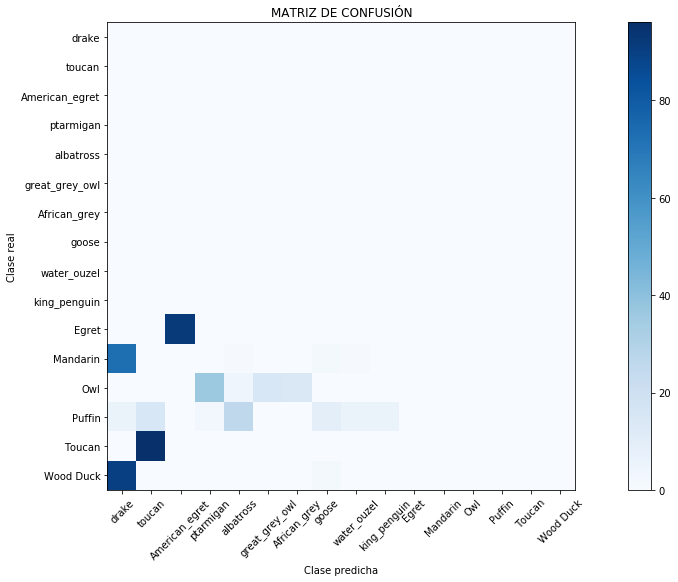

In [36]:
plt.figure(figsize=(15,8))
plot_confusion_matrix(cm,labels)

**Resultado final: ** Es claro que la predicción no es buena para las 600 fotos, esto debido al pre-entrenamiento de la red neuronal VGG16 que no incorporo imágenes explicitas de aves tipo *"Egret","Mandarin","Owl","Puffin","Toucan" y "Wood Duck"*. Como resultado curioso y a modo de ejemplo, vemos que 241 aves fueron clasificadas erráticamente como "Shower_curtain" discriminadas así:

**clasificadas equivocadamente como -shower_curtain-**
* 38 Egret	
* 48 Mandarin	
* 29 Owl	
* 42 Puffin	
* 43 Toucan	
* 41 Wood Duck

# *Punto 2. Transfer Learning*

Se importan las librerías a utilizar: ImageDataGenerator que permite aumentar el tamaño de muestra generando, por ejemplo,  rotaciones en las imágenes y las otras que sirven para estructurar las redes.

In [37]:
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras import applications
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt
import math

Ejemplo de una de las imágenes disponibles:

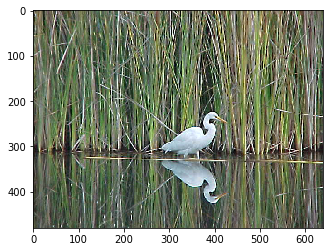

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img,image

img = load_img('birds/egret/egr001.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, 150, 150)
plt.imshow(img)
plt.show()

Ejemplo de rotación generad por el ImageDataGenerator:

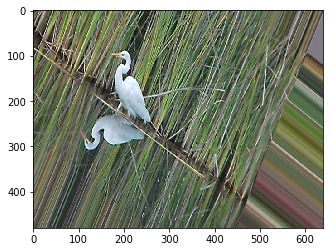

In [39]:
datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

img = load_img('birds/egret/egr001.jpg')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array with shape (3, _, _)
x = x.reshape((1,) + x.shape)  # this is a Numpy array with shape (1, 3, _, _)

# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `preview/` directory
i = 0
for batch in datagen.flow(x, batch_size=1):
    i += 1
    if i > 20:
        break  # otherwise the generator would loop indefinitely
plt.imshow(batch[0]/255) 
plt.show()

### Construcción del modelo

Se define la dimensión de las imágenes y se importan los datos:

In [40]:
img_width, img_height = 224, 224
top_model_weights_path = 'bottleneck_fc_model.h5'
train_data_dir = 'train'
test_data_dir = 'test'
epochs = 50
batch_size = 16

A continuación se crea el data generator para las imágenes de entrenamiento. Luego, se aplica el modelo VGG16 a estas imágenes para extraer las características y almacenarlas. Dichas características servirán para alimentar la última capa del modelo, que reemplaza a la última capa del VGG16. Cabe mencionar que las imágenes se reescalan para tener valores entre 0 y 1 en las matrices RGB.

In [ ]:
model   = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255) #se reescala para que queden valores entre 0 y 1 
    
generator = datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices) 
predict_size_train = int(math.ceil(nb_train_samples / batch_size)) 

bottleneck_features_train = model.predict_generator(generator, predict_size_train)
np.save('bottleneck_features_train.npy', bottleneck_features_train)


54575104/58889256 [==========================>...] - ETA: 4s

Se valida la cantidad de imágenes disponibles para entrenamiento:

In [ ]:
nb_train_samples

Se valida la cantidad de clases identificadas en los datos:

In [ ]:
num_classes

Se aplica el mismo proceso mencionado anteriormente para las imágenes del set de test:

In [54]:
generator = datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False)

nb_test_samples = len(generator.filenames)
predict_size_test = int(math.ceil(nb_test_samples / batch_size))

bottleneck_features_test = model.predict_generator(generator, predict_size_test)
np.save('bottleneck_features_test.npy', bottleneck_features_test)

Found 300 images belonging to 6 classes.


Para poder crear la parte final del modelo, se requiere crear las etiquetas de las clases para  las muestras de train y test, para lo cual también se emplea la función 'DataGenerator'. Luego, las etiquetas se convierten en variables categóricas.

In [55]:
datagen_top = ImageDataGenerator(rescale=1./255)
generator_top = datagen_top.flow_from_directory(
    train_data_dir, 
    target_size=(img_width, img_height),
    class_mode='categorical',
    shuffle=False)

nb_train_samples = len(generator.filenames)
num_classes = len(generator.class_indices)

# Carga los outputs del vgg16  
train_data = np.load('bottleneck_features_train.npy')  
   
# Obtiene las clases en el orden original
train_labels = generator_top.classes  
   
# Conversión de las clases a variables categóricas
train_labels = to_categorical(train_labels, num_classes=num_classes) 

Found 300 images belonging to 6 classes.


A continuación un ejemplo de las variables categóricas:

In [56]:
train_labels

array([[1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 1.]], dtype=float32)

Realizamos lo mismo para las imágenes de test:

In [58]:
generator_top = datagen_top.flow_from_directory(  
        test_data_dir,  
        target_size=(img_width, img_height),  
        batch_size=batch_size,  
        class_mode=None,  
        shuffle=False)  
   
nb_test_samples = len(generator_top.filenames)  
   
test_data = np.load('bottleneck_features_test.npy')  
   
test_labels = generator_top.classes  
test_labels = to_categorical(test_labels, num_classes=num_classes) 

Found 300 images belonging to 6 classes.


In [59]:
test_labels.shape

(300, 6)

El paso siguiente es conectar la parte de la red "personalizada" o top model, que es la que permite materializar el transfer learning, aprovechando las características extraídas con la aplicación del VGG16, las cuales serán el input. El output serán las clases que queremos predecir.

In [82]:
from keras.optimizers import rmsprop
model = Sequential()  
model.add(Flatten(input_shape=train_data.shape[1:]))  
model.add(Dense(256, activation='relu'))  
model.add(Dropout(0.5))  
model.add(Dense(6, activation='sigmoid'))  
   
model.compile(optimizer=rmsprop(lr=0.0001, rho=0.9, epsilon=None, decay=0.0),loss='categorical_crossentropy', metrics=['accuracy'])  
   
history = model.fit(train_data, train_labels,  
         epochs=epochs,  
         batch_size=batch_size,  
         validation_data=(test_data, test_labels))  
   
model.save_weights(top_model_weights_path)  
   

Train on 300 samples, validate on 300 samples
Epoch 1/50
300/300 [==============================] - 5s 18ms/step - loss: 1.7346 - acc: 0.2967 - val_loss: 1.4370 - val_acc: 0.4000
Epoch 2/50
300/300 [==============================] - 5s 16ms/step - loss: 1.1367 - acc: 0.5967 - val_loss: 0.8487 - val_acc: 0.7333
Epoch 3/50
300/300 [==============================] - 6s 19ms/step - loss: 0.7120 - acc: 0.7833 - val_loss: 0.6254 - val_acc: 0.8300
Epoch 4/50
300/300 [==============================] - 6s 19ms/step - loss: 0.5853 - acc: 0.8433 - val_loss: 0.7339 - val_acc: 0.7167
Epoch 5/50
300/300 [==============================] - 5s 17ms/step - loss: 0.3702 - acc: 0.9133 - val_loss: 0.4817 - val_acc: 0.8633
Epoch 6/50
300/300 [==============================] - 5s 16ms/step - loss: 0.3460 - acc: 0.9200 - val_loss: 0.4312 - val_acc: 0.8767
Epoch 7/50
300/300 [==============================] - 5s 16ms/step - loss: 0.2309 - acc: 0.9533 - val_loss: 0.4732 - val_acc: 0.8400
Epoch 8/50
300/300 [===

Se prueba el modelo en los **datos de test**, evaluando las medidas de desempeño de accuracy y la función de pérdida.

In [83]:
(eval_loss, eval_accuracy) = model.evaluate(test_data, test_labels, batch_size=batch_size, verbose=1)

300/300 [==============================] - 0s 1ms/step


In [84]:
eval_accuracy

0.9133333333333333

In [85]:
eval_loss

0.29709087431430814

In [86]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               6422784   
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)                 1542      
Total params: 6,424,326
Trainable params: 6,424,326
Non-trainable params: 0
_________________________________________________________________


En las siguientes gráficas se muestra el desempeño del accuracy y la función de pérdida conforme se avanza en los epochs. Se observa que se alcanza un comportamiento esperado en el que el accuracy mejora y la función de pérdida disminuye.

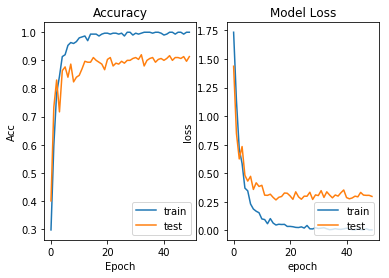

In [87]:
plt.figure(1)
plt.subplot(121)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('Accuracy')  
plt.ylabel('Acc')  
plt.xlabel('Epoch')  
plt.legend(['train', 'test'], loc='lower right')


plt.subplot(122)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Model Loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='lower right')  
plt.show() 

Predicción del modelo en probabilidades:

In [88]:
print(model.predict(test_data))

[[1.26424536e-01 5.15850661e-05 4.62599928e-06 1.66429299e-06
  9.95184600e-05 1.82046642e-05]
 [7.89246615e-03 5.75559966e-07 1.36590117e-07 1.06471795e-07
  1.62631390e-04 2.45434330e-05]
 [2.07534321e-02 9.21354015e-08 1.49017723e-08 5.14379622e-07
  5.35046682e-04 3.71898068e-08]
 ...
 [2.31726260e-09 5.60207354e-06 6.26020213e-09 3.66849306e-09
  1.06998044e-07 3.84857394e-02]
 [2.82445058e-07 8.06261232e-06 1.50929139e-07 2.48191700e-05
  6.99449458e-08 7.85300508e-03]
 [4.79506207e-06 1.92170346e-03 1.82282811e-08 2.30761330e-08
  1.61666577e-07 2.59543121e-01]]


Convirtiendo las probabilidades en clases tenemos lo siguiente:

In [89]:
print(model.predict_classes(test_data))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 3 0 0 0 0 0 1 1 1 1 1 4 1 4 1 1 3 1 1 1 1 1 1 1 1 3 1 1 1 1
 1 1 1 5 0 5 1 1 1 3 1 1 1 5 1 1 1 1 5 2 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 3 2 2 2 2 2 2 3 2 2 3 2 2 3 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 3 2 2 2 2
 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 2 3 3 3 1 3 3 3 3 3 3 3 3 3 3 3 3 3 4 3 3
 3 3 3 3 3 3 3 3 3 3 3 5 3 3 3 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 1 4 4 4 4 4 4 4 4 4 4 5 5 2 5 5 5 5 5 5
 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 5 5 5 5 5 3 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 5 5]


In [90]:
test_labels1 = generator_top.classes 

In [91]:
test_labels1

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5])

## Matriz de confusión

In [71]:
from sklearn.metrics import confusion_matrix 
cm = confusion_matrix(test_labels1, model.predict_classes(test_data))

In [72]:
cm

array([[45,  1,  0,  4,  0,  0],
       [ 1, 46,  0,  1,  1,  1],
       [ 0,  1, 44,  5,  0,  0],
       [ 0,  4,  1, 42,  1,  2],
       [ 2,  4,  0,  0, 44,  0],
       [ 0, 17,  0,  0,  0, 33]], dtype=int64)

In [92]:
def plot_confusion_matrix(cm, names, title='MATRIZ DE CONFUSIÓN', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('Clase real')
    plt.xlabel('Clase predicha')

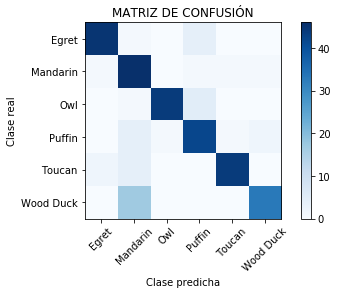

In [93]:
plt.figure()
plot_confusion_matrix(cm, ['Egret','Mandarin','Owl','Puffin','Toucan','Wood Duck'])

#### *Conclusión: Al analizar la diagonal de la matriz de confusión se evidencia que el modelo tiene muy buen desempeño, ya que clasifica correctamente la mayoría de aves en la categoría esperada, siendo la clase mejor clasificada la correspondiente a 'Wood duck'. La clase con peor desempeño es 'Mandarin', como se puede constatar en el heatmap de la matriz de confusión.*